<a href="https://colab.research.google.com/github/da03/REBM/blob/main/REBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Residual Energy-Based Models for Text Generation

This notebook implements the Residual Energy-Based Model as described in [Residual Energy-Based Models for Text Generation](https://openreview.net/pdf?id=B1l4SgHKDH). Note that both data and model (generator+discriminator) are different from the original paper: the goal is just to show how the entire pipeline works, using much less computational resource.

The entire pipeline consists of three steps:

1. Train a base autoregressive language model (generator, or LM, or base LM) $P_{LM}$;

2. Sample from the base LM $P_{LM}$ and dump samples to disk;

3. Train a discriminator to classify real data versus model generations such that $P(x=real) = \text{sigmoid}(-E_\theta (x))$.

After these three steps, the generator and the discriminator defines a joint generative model of text:

$P_{joint}(x) \propto P_{LM}(x) \exp(-E_\theta(x))$

In order to sample from the joint model, we first sample a set of samples from base LM $P_{LM}$, then we resample from this set with probability proportional to $\exp (-E_\theta(x))$. This is summarized in Algorithm 1 in the original paper, and we can prove that as the number of samples from base LM approaches infinity, this sample-resample procedure approaches exact sampling from the joint distribution.

## Setup

First, define some global control flags.

In [1]:
# Global flags
WORKING_DIR = 'REBM'
OVERWRITE_DATA = False
RETRAIN_GENERATOR = False
if OVERWRITE_DATA and (not RETRAIN_GENERATOR):
  print ('Warning: generator should be retrained since data is regenerated!')

RESAMPLE = False
if RETRAIN_GENERATOR and (not RESAMPLE):
  print ('Warning: should be resampled since generator is retrained!')

RETRAIN_PRETRAIN = False
if OVERWRITE_DATA and RETRAIN_PRETRAIN:
  print ('Warning: pretraining should be done again since data is overwritten!')

Next, connect to Google Drive to save intermediate checkpoits/generated data, etc.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
working_directory = f'/content/drive/MyDrive/{WORKING_DIR}'
! mkdir -p $working_directory
%cd $working_directory

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/REBM


In [3]:
if not os.path.exists('mingpt'):
  os.system('git clone https://github.com/da03/minGPT.git')
  os.system('cp -r minGPT/mingpt ./')

In [4]:
import math
import warnings
import copy
import os
import io
import re
import random

import torch
import torch.nn as nn
import torchtext as tt
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from mingpt.trainer import Trainer, TrainerConfig
from mingpt.model import *

In [5]:
# GPU check, make sure to use GPU where available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

cuda


## Data Generation

We construct a synthetic language of arithmetic expressions. To be more precise, we consider the task of adding two 10-digit numbers together. One example from the dataset is shown below:

```
1 0 7 6 0 9 9 7 2 3 + 7 3 8 0 1 6 5 7 2 6 = 0 8 4 5 6 2 6 5 4 4 9
```

The task we use here is language modeling on this dataset. The benefit of using such a task is that we can evaluate the quality of samples from the model by evaluating whether the generated equation is correct, unlike in unconstrained language modeling of natural languages which usually requires human evaluation.

Note that here we use this dataset for unconditional language modeling for simplicity of implementation, although it appears more natural to do conditional language modeling which gives the model a prefix of the left-hand-side of the equation.


In [6]:
# Generate data
train_file = 'data/train.txt'
val_file = 'data/val.txt'
test_file = 'data/test.txt'
files = [train_file, val_file, test_file]

if not all([os.path.exists(d) for d in files]):
  if not OVERWRITE_DATA:
    print ('rewriting data since it doesn\'t exist!')
    OVERWRITE_DATA = True

if OVERWRITE_DATA:
  numbers = set([])
  np.random.seed(1234)
  num_digits = 10
  dataset_size = 200000
  min_num = 10**(num_digits-1)
  max_num = 10**(num_digits)
  numbers = np.random.randint(min_num, max_num, size=dataset_size)

  numbers = set(numbers)
  numbers = list(numbers)
  
  random.seed(1234)
  random.shuffle(numbers)
  os.system(f'mkdir -p {os.path.dirname(train_file)}')
  with open(f'{train_file}.tmp', 'w') as ftrain:
    with open(f'{val_file}.tmp', 'w') as fval:
      with open(f'{test_file}.tmp', 'w') as ftest:
        for num in numbers[:700]:
          ftest.write(f'{" ".join([c for c in str(num)])}\n')
        for num in numbers[700:1400]:
          fval.write(f'{" ".join([c for c in str(num)])}\n')
        for num in numbers[1400:]:
          ftrain.write(f'{" ".join([c for c in str(num)])}\n')

  def transform_data(input_file, output_file):
    with open(input_file) as fin:
      with open(output_file, 'w') as fout:
        lines = fin.readlines()
        numbers1 = lines[:(len(lines)//2)]
        numbers2 = lines[(len(lines)//2):]
        for number1, number2 in zip(numbers1, numbers2):
          num1 = int(number1.replace(' ', '').strip())
          num2 = int(number2.replace(' ', '').strip())
          result = num1 + num2
          result = str(result)
          result = ' '.join([i for i in result])
          if True:
            number1 = '%010d' % num1
            number1 = ' '.join([i for i in number1])
            number2 = '%010d' % num2
            number2 = ' '.join([i for i in number2])
            result = int(result.replace(' ', ''))
            result = '%011d' % result
            result = ' '.join([i for i in result])
          fout.write(f'{number1.strip()} + {number2.strip()} = {result}\n')

  transform_data(f'{train_file}.tmp', train_file)
  transform_data(f'{val_file}.tmp',   val_file)
  transform_data(f'{test_file}.tmp',  test_file)

rewriting data since it doesn't exist!


Let's take a look at the data used for language modeling.

In [7]:
!head data/val.txt

8 9 1 2 8 9 6 0 6 2 + 9 6 6 6 9 6 3 1 6 7 = 1 8 5 7 9 8 5 9 2 2 9
1 0 7 6 0 9 9 7 2 3 + 7 3 8 0 1 6 5 7 2 6 = 0 8 4 5 6 2 6 5 4 4 9
6 0 2 3 2 2 0 3 8 6 + 4 0 1 0 6 0 8 9 5 2 = 1 0 0 3 3 8 2 9 3 3 8
5 1 8 7 3 9 5 3 6 6 + 6 8 5 7 7 9 2 6 0 2 = 1 2 0 4 5 1 8 7 9 6 8
1 1 3 5 6 4 3 5 2 8 + 3 0 8 5 0 1 1 1 1 0 = 0 4 2 2 0 6 5 4 6 3 8
2 6 0 7 0 5 1 3 2 1 + 5 8 2 7 7 9 9 4 7 2 = 0 8 4 3 4 8 5 0 7 9 3
1 4 4 6 0 0 9 3 9 6 + 6 3 4 7 7 3 0 6 7 0 = 0 7 7 9 3 7 4 0 0 6 6
5 6 5 4 5 2 1 5 9 5 + 8 8 1 4 9 7 6 5 0 6 = 1 4 4 6 9 4 9 8 1 0 1
5 7 7 3 9 3 0 8 5 6 + 3 3 4 9 7 7 6 9 5 9 = 0 9 1 2 3 7 0 7 8 1 5
5 1 9 3 2 8 4 5 0 3 + 2 5 5 2 3 7 8 4 9 1 = 0 7 7 4 5 6 6 2 9 9 4


## Data Preprocessing

We use torchtext to load data.

In [8]:
# adapted from https://github.com/pytorch/text/blob/master/torchtext/legacy/datasets/language_modeling.py
class LanguageModelingDataset(tt.legacy.data.Dataset):
    """Defines a dataset for language modeling."""
    name = 'LM'
    def __init__(self, path, text_field, newline_eos=True,
                 encoding='utf-8', **kwargs):
        """Create a LanguageModelingDataset given a path and a field.
        Args:
            path: Path to the data file.
            text_field: The field that will be used for text data.
            newline_eos: Whether to add an <eos> token for every newline in the
                data file. Default: True.
            encoding: The encoding of the file.
            kwargs: Passed to the constructor of
                data.Dataset.
        """
        fields = [('text', text_field)]
        examples = []
        with io.open(path, encoding=encoding) as f:
            for line in f:
                text = text_field.preprocess(line)
                if newline_eos:
                    text.append(u'<eos>')
                examples.append(tt.legacy.data.Example.fromlist([text], fields))
        super(LanguageModelingDataset, self).__init__(
            examples, fields, **kwargs)

In [9]:
TEXT = tt.legacy.data.Field(include_lengths=False, # do not include lengths
                    batch_first=False,            # batches will be max_len x batch_size
                    tokenize=lambda x: x.split(), # use split to tokenize
                    init_token="<bos>",           # prepend <bos>
                    eos_token="<eos>"
)

# Make splits for data
train_data, val_data, test_data = LanguageModelingDataset.splits(
    path='./data', root='.', train='train.txt', validation='val.txt', test='test.txt',  
    text_field=TEXT, newline_eos=False,
)

# Build vocabulary
TEXT.build_vocab(train_data.text)

print ("Vocab: ", TEXT.vocab.itos)

Vocab:  ['<unk>', '<pad>', '<bos>', '<eos>', '1', '0', '7', '2', '3', '5', '8', '6', '9', '4', '+', '=']


In [10]:
BATCH_SIZE = 512
train_iter, val_iter, test_iter = tt.legacy.data.BucketIterator.splits((train_data, val_data, test_data),
                                                     batch_size=BATCH_SIZE, 
                                                     device=device,
                                                     repeat=False, 
                                                     sort_key=lambda x: len(x.text), # sort by length to minimize padding
                                                     sort_within_batch=True)

In [11]:
batch = next(iter(train_iter))
text = batch.text
print (f"Size of text batch: {text.shape}")
print (f"Third text sentence in batch: {text[:, 2]}")
print (f"Converted back to string: {' '.join([TEXT.vocab.itos[i] for i in text[:, 2]])}")

Size of text batch: torch.Size([35, 512])
Third text sentence in batch: tensor([ 2, 10,  4,  4,  6,  4,  8,  7,  9,  8,  6, 14,  9,  8,  8, 11,  6,  8,
         6,  4, 12,  7, 15,  4,  8, 13,  9,  8, 10, 11, 12,  6,  7, 12,  3],
       device='cuda:0')
Converted back to string: <bos> 8 1 1 7 1 3 2 5 3 7 + 5 3 3 6 7 3 7 1 9 2 = 1 3 4 5 3 8 6 9 7 2 9 <eos>


## Training Base LM (Generator)

We then train a base language model (base LM, or generator) on the dataset. Here we use an LSTM (without attention) as the generator, which cannot solve this task. Note that we can solve this task perfectly using a transformer generator, but for the purpose of illustration we use an LSTM instead.

In [12]:
class Generator(nn.Module):
  def __init__(self, text_field, embedding_size=64, hidden_size=64, layers=3):
    """
    Initializer. Creates network modules and loss function.
    Arguments:
        text_field: text field
        embedding_size: word embedding size
        hidden_size: hidden layer size of both encoder and decoder
        layers: number of layers of both encoder and decoder
    """
    super(Generator, self).__init__()
    self.text_field = text_field
    
    # Keep the vocabulary size available
    self.V = len(text_field.vocab.itos)
    
    # Get special word ids or tokens
    self.padding_id = text_field.vocab.stoi[text_field.pad_token]
    self.bos_id = text_field.vocab.stoi[text_field.init_token]
    self.eos_id = text_field.vocab.stoi[text_field.eos_token]

    # Keep hyper-parameters available
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.layers = layers

    # Create essential modules
    self.word_embeddings = nn.Embedding(self.V, embedding_size)

    # RNN cell
    self.rnn = nn.LSTM(
      input_size    = embedding_size,
      hidden_size   = hidden_size,
      num_layers    = layers,
      bidirectional = False
    )

    # Final projection layer
    self.hidden2output = nn.Linear(hidden_size, self.V)

    # Create loss function
    self.loss_function = nn.CrossEntropyLoss(reduction='sum', 
                                             ignore_index=self.padding_id)

  def forward(self, text_in):
    """
    Performs forward computation, returns logits.
    Arguments:
        text_in: decoder input
    """
    # Compute word embeddings
    embeddings = self.word_embeddings(text_in) # tgt_len, bsz, hidden
    # Forward RNN and return all hidden states
    outs, _ = self.rnn(embeddings)
    # Project to get logits
    logits = self.hidden2output(outs) # tgt_len, bsz, V
    return logits

  def forward_incrementally(self, state, text_in):
    """
    Forward the model at `state` for a single step with token `text_in`.
    This function will only be used in the beam search section.
    Arguments:
        state: a tuple (h, c) where h/c is of size (layers, 1, hidden_size)
        text_in: a tensor of size (bsz), tokens for a single step
    Returns:
        `logits`: Log probabilities for `tgt_in` of size (V)
        `state`: updated state, ready for next incremental update
    """
    # Compute word embeddings
    embeddings = self.word_embeddings(text_in.view(1, -1)) # tgt_len, bsz, hidden
    # Forward RNN and return all hidden states
    outs, state = self.rnn(embeddings, state)
    # Project to get logits
    logits = self.hidden2output(outs) # tgt_len, bsz, V
    # Get log probabilities
    logits = torch.log_softmax(logits, -1) # tgt_len, bsz, V
    return logits[0], state

  def evaluate_ppl(self, iterator):
    """Returns the model's perplexity on a given dataset `iterator`."""
    # Switch to eval mode
    self.eval()
    total_loss = 0
    total_words = 0
    for batch in iterator:
      # Input and target
      text = batch.text
      text_in = text[:-1] # remove <eos> for decode input (y_0=<bos>, y_1, y_2)
      text_out = text[1:] # remove <bos> as target        (y_1, y_2, y_3=<eos>)
      # Forward to get logits
      logits = self.forward(text_in)
      # Compute cross entropy loss
      loss = self.loss_function(logits.view(-1, self.V), text_out.view(-1))
      total_loss += loss.item()
      total_words += text_out.ne(self.padding_id).float().sum().item()
    return math.exp(total_loss/total_words)

  def predict(self, bsz, prefix, max_len=33):
    self.eval()
    state = None
    prev_token = torch.LongTensor([self.bos_id]).to(device).view(1, 1).repeat(1, bsz)
    i = 0
    if prefix is not None:
      prev_token = torch.cat([prev_token, prefix], 0)
      i = prefix.size(0)
      feed = prev_token[:-1]
      embeddings = self.word_embeddings(feed) # tgt_len, bsz, hidden
      # Forward RNN and return all hidden states
      _, state = self.rnn(embeddings, state)
      prev_token = prev_token[-1:]

    sample = []
    finished = torch.zeros(bsz).eq(1)
    while i < max_len:
      i += 1
      logits, state = self.forward_incrementally(state, prev_token)
      token = torch.multinomial(logits.exp(), 1).view(-1)
      token[finished] = self.eos_id
      sample.append(token)
      prev_token = token
      finished[token.eq(self.eos_id)] = True
      if finished.all():
        break
    sample = torch.stack(sample, -1)
    if prefix is not None:
      sample = torch.cat([prefix.transpose(0,1), sample], -1)
    samples = []
    for i in range(bsz):
      samples.append(' '.join([self.text_field.vocab.itos[item] for item in sample[i] if item != self.eos_id]))
    return samples

  def train_all(self, train_iter, val_iter, epochs=10, learning_rate=0.001):
    """Train the model."""
    # Switch the module to training mode
    self.train()
    # Use Adam to optimize the parameters
    optim = torch.optim.Adam(self.parameters(), lr=learning_rate)
    best_validation_ppl = float('inf')
    best_model = None
    val_ppls = []
    # Run the optimization for multiple epochs
    for epoch in range(epochs): 
      total_words = 0
      total_loss = 0.0
      for batch in train_iter:
        # Zero the parameter gradients
        self.zero_grad()
        # Input and target
        text = batch.text # text: max_src_length, bsz
        text_in = text[:-1] # Remove <eos> for decode input (y_0=<bos>, y_1, y_2)
        text_out = text[1:] # Remove <bos> as target        (y_1, y_2, y_3=<eos>)
        batch_size = text_in.size(1)
        # Run forward pass and compute loss along the way.
        logits = self.forward(text_in)
        loss = self.loss_function(logits.view(-1, self.V), text_out.view(-1))
        # Training stats
        num_words = text_out.ne(self.padding_id).float().sum().item()
        total_words += num_words
        total_loss += loss.item()
        # Perform backpropagation
        loss.div(batch_size).backward()
        optim.step()

      # Evaluate and track improvements on the validation dataset
      validation_ppl = self.evaluate_ppl(val_iter)
      val_ppls.append(validation_ppl)
      self.train()
      if validation_ppl < best_validation_ppl:
        best_validation_ppl = validation_ppl
        self.best_model = copy.deepcopy(self.state_dict())
      epoch_loss = total_loss / total_words
      print (f'Epoch: {epoch} Training Perplexity: {math.exp(epoch_loss):.4f} '
             f'Validation Perplexity: {validation_ppl:.4f}')
    return val_ppls

have to retrain generator since it does not exist!
Epoch: 0 Training Perplexity: 9.0339 Validation Perplexity: 7.7329
Epoch: 1 Training Perplexity: 8.0540 Validation Perplexity: 7.6389
Epoch: 2 Training Perplexity: 7.5453 Validation Perplexity: 7.4878
Epoch: 3 Training Perplexity: 7.4417 Validation Perplexity: 7.4080
Epoch: 4 Training Perplexity: 7.3732 Validation Perplexity: 7.3557
Epoch: 5 Training Perplexity: 7.3251 Validation Perplexity: 7.2906
Epoch: 6 Training Perplexity: 7.2769 Validation Perplexity: 7.2385
Epoch: 7 Training Perplexity: 7.2392 Validation Perplexity: 7.2253
Epoch: 8 Training Perplexity: 7.2058 Validation Perplexity: 7.1780
Epoch: 9 Training Perplexity: 7.1738 Validation Perplexity: 7.2138
Epoch: 10 Training Perplexity: 7.1508 Validation Perplexity: 7.1515
Epoch: 11 Training Perplexity: 7.1267 Validation Perplexity: 7.0972
Epoch: 12 Training Perplexity: 7.1012 Validation Perplexity: 7.0830
Epoch: 13 Training Perplexity: 7.0848 Validation Perplexity: 7.0856
Epoch: 

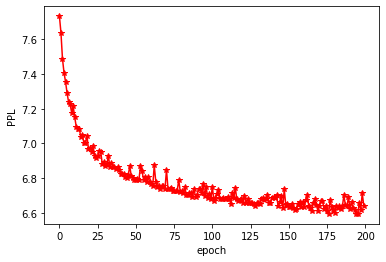

In [13]:
generator_path = 'data/generator.pt'

# Instantiate and train classifier
generator = Generator(TEXT,
  embedding_size = 256,
  hidden_size    = 256,
  layers         = 1,
).to(device)

if not os.path.exists(generator_path):
  if not RETRAIN_GENERATOR:
    print ('have to retrain generator since it does not exist!')

if RETRAIN_GENERATOR or (not os.path.exists(generator_path)):
  EPOCHS = 200
  LEARNING_RATE = 6e-4

  val_ppls = generator.train_all(train_iter, val_iter, epochs=EPOCHS, learning_rate=LEARNING_RATE)
  generator.load_state_dict(generator.best_model)
  
  plt.plot(range(len(val_ppls)), val_ppls, 'r*-')
  plt.xlabel('epoch')
  plt.ylabel('PPL')

  torch.save(generator.state_dict(), generator_path)
else:
  generator.load_state_dict(torch.load(generator_path))

With a trained generator, we can evaluate the quality of the generated samples. We use per-digit accuracy since per-equation accuracy would be too low to be informative.

In [14]:
# Evaluation Metrics
def num_of_correct(expression):
  expression = expression.replace(' ', '')
  m = re.match(r'(\d+)\+(\d+)=(\d+)', expression)
  if not m:
    print (expression)
    return 0, 0, 0
  a = m.group(1)
  b = m.group(2)
  res = int(a) + int(b)
  res = '%011d' % res
  tot = max(len(res), len(m.group(3)))
  correct_pos = 0
  correct_len = 1 if len(m.group(3)) == len(res) else 0
  for c1, c2 in zip(res, m.group(3)):
    if c1 == c2:
      correct_pos += 1
  return correct_pos / tot, correct_len

In [15]:
num_samples = 100

total = 0
num_correct_pos = 0.
num_correct_len = 0.
for i in range(num_samples):
  sample = generator.predict(1, None)[0]
  c_pos, c_len = num_of_correct(sample)
  num_correct_pos += c_pos
  num_correct_len += c_len
  total += 1
  sample_orig = sample
  sample = sample.replace(' ', '')
  m = re.match(r'(\d+)\+(\d+)=(\d+)', sample)
  a = int(m.group(1))
  b = int(m.group(2))
  c = a+b
  c = '%011d'%c
  print (sample_orig + ' | ' + ' '.join(c))
print (num_correct_pos/total)
print (num_correct_len/total)

6 9 2 8 7 1 4 4 6 3 + 6 4 4 7 2 2 2 6 1 4 = 1 3 2 9 4 7 5 1 9 2 9 | 1 3 3 7 5 9 3 7 0 7 7
5 9 9 0 9 8 9 1 2 2 + 6 6 5 6 9 6 3 0 8 6 = 1 2 6 3 2 3 9 4 2 7 4 | 1 2 6 4 7 9 5 2 2 0 8
7 2 9 4 2 0 2 4 6 1 + 3 3 4 0 0 0 7 3 6 6 = 1 0 6 3 4 5 0 9 0 9 7 | 1 0 6 3 4 2 0 9 8 2 7
3 4 1 8 1 3 1 4 7 5 + 4 5 5 1 7 3 5 5 9 2 = 0 7 9 2 3 0 7 1 6 6 1 | 0 7 9 6 9 8 6 7 0 6 7
2 6 3 7 5 1 0 4 8 6 + 3 3 3 3 4 8 5 1 5 5 = 0 5 9 7 8 7 4 6 1 8 0 | 0 5 9 7 0 9 9 5 6 4 1
5 0 5 0 2 5 5 6 3 5 + 2 2 7 2 7 4 2 3 3 2 = 0 7 3 4 8 4 0 1 2 8 9 | 0 7 3 2 2 9 9 7 9 6 7
4 3 8 2 1 4 1 4 5 2 + 8 4 4 4 0 2 7 6 4 4 = 1 2 8 0 2 1 8 2 8 6 2 | 1 2 8 2 6 1 6 9 0 9 6
5 4 3 0 7 5 4 0 2 5 + 2 1 3 9 8 9 0 6 2 0 = 0 7 6 1 1 2 1 3 0 4 0 | 0 7 5 7 0 6 4 4 6 4 5
5 7 8 3 3 6 0 6 4 9 + 7 9 8 6 0 3 7 1 9 8 = 1 3 6 9 7 6 4 4 3 3 9 | 1 3 7 6 9 3 9 7 8 4 7
2 3 5 9 1 5 6 5 4 4 + 9 7 6 4 5 8 1 8 0 4 = 1 2 2 1 2 3 9 8 4 2 2 | 1 2 1 2 3 7 3 8 3 4 8
9 9 7 6 3 9 0 3 0 6 + 6 5 8 2 4 2 1 1 4 8 = 1 6 5 5 4 0 1 4 7 0 8 | 1 6 5 5 8 8 1 1 4 5 4
7 5 6 5 1 

## Sampling from Base LM

Now, we sample from the base LM (generator) to prepare the data we need for training the discriminator.

In [16]:
train_file = f'data/LM_generated/train.txt'
val_file = f'data/LM_generated/val.txt'
test_file = f'data/LM_generated/test.txt'

files = [train_file, val_file, test_file]

if not (all([os.path.exists(f) for f in files])):
  if not RESAMPLE:
    print ('needs to resample data!')

if RESAMPLE or (not (all([os.path.exists(f) for f in files]))):
  if not os.path.exists('data/LM_generated'):
    os.makedirs('data/LM_generated')
  def sample_data(data_iter, fout):
    for batch in tqdm(data_iter):
        bsz = batch.text.size(1)
        sample = generator.predict(bsz, None)
        for s in sample:
          fout.write(s+'\n')

  with open(f'data/LM_generated/train.txt', 'w') as fout:
    sample_data(train_iter, fout)
  with open(f'data/LM_generated/val.txt', 'w') as fout:
    sample_data(val_iter, fout)
  with open(f'data/LM_generated/test.txt', 'w') as fout:
    sample_data(test_iter, fout)

  0%|          | 0/194 [00:00<?, ?it/s]

needs to resample data!


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


As before, we need to load those generated data using torchtext.

In [17]:
# Make splits for data
lmgen_train_data, lmgen_val_data, lmgen_test_data = LanguageModelingDataset.splits(
    path='./data/LM_generated', root='.', train='train.txt', validation='val.txt', test='test.txt',  
    text_field=TEXT, newline_eos=False,
)

In [18]:
lmgen_train_iter, lmgen_val_iter, lmgen_test_iter = tt.legacy.data.BucketIterator.splits(
                                                     (lmgen_train_data, lmgen_val_data, lmgen_test_data),
                                                     batch_size=BATCH_SIZE, 
                                                     device=device,
                                                     repeat=False, 
                                                     sort_key=lambda x: len(x.text), # sort by length to minimize padding
                                                     sort_within_batch=True)

## Training Discriminator

With generated samples (negatives), and the original real data (positives), we can train a discriminator to distinguish real versus fake. The pre-sigmoid outputs of the discriminator will be used as a residual over the log likelihood $\log P_{LM}$ to define a joint model REBM.

We use a bi-directional transformer as our discriminator. Our preliminary experiments using an LSTM-based discriminator will also lead to improvements, but transformers are much faster to train and lead to larger improvements so we ended up using it.

In [19]:
# train a discriminator
class Discriminator(nn.Module):
  def __init__(self, text_field, hidden_size=128, layers=2, heads=4):
    """
    Initializer. Creates network modules and loss function.
    Arguments:
        text_field: text field
        hidden_size: word embedding size and hidden size
        layers: number of layers
        heads: number of heads
    """
    super(Discriminator, self).__init__()
    self.text_field = text_field
    
    # Keep the vocabulary sizes available
    self.V = len(text_field.vocab.itos)
    
    # Get special word ids or tokens
    self.padding_id = text_field.vocab.stoi[text_field.pad_token]
    self.bos_id = text_field.vocab.stoi[text_field.init_token]
    self.eos_id = text_field.vocab.stoi[text_field.eos_token]

    # Keep hyper-parameters available
    self.hidden_size = hidden_size
    self.layers = layers
    self.heads = heads

    # Final projection layer
    self.hidden2output = nn.Linear(hidden_size, 2)

    # Final projection layer for masked-LM pretraining
    self.hidden2output_pretrain = nn.Linear(hidden_size, self.V)

    self.loss_function = nn.CrossEntropyLoss(reduction='sum')

    self.loss_function_pretrain = nn.CrossEntropyLoss(reduction='sum', ignore_index=0)
    
    mconf = GPTConfig(self.V, 50,
                  n_layer=layers, n_head=heads, n_embd=hidden_size)
    self.model = GPT(mconf)
    def f(m):
      m.causal = False
    self.model.apply(f) # make GPT model use bidirectional attention

  def extract_features(self, text):
    """
    Extract features from `text`.
    Arguments:
        text: text batch of size (max_len, batch_size)
    Returns:
        features of size (max_len, bsz, hidden_size) 
    """
    # Compute word embeddings
    bsz = text.size(1)
    seq_len = text.size(0)

    all_contexts = self.model.extract_features(text.transpose(0, 1))
    all_contexts = all_contexts.transpose(0, 1) # seq_len, bsz, hidden
    return all_contexts

  def forward_pretrain(self, text):
    all_contexts = self.extract_features(text) # seq_len, bsz, hidden
    logits = self.hidden2output_pretrain(all_contexts) # seq_len, bsz, V
    return logits

  def forward(self, text):
    """
    Performs forward computation, returns logits.
    Arguments:
        text: batch of size (max_len, batch_size)
    """
    all_contexts = self.extract_features(text)
    state = all_contexts.mean(0)
    logits = self.hidden2output(state)
    return logits

  def pretrain_all(self, real_train_iter, real_val_iter,
                   epochs=50, learning_rate=6e-4, mask=0.3, accumulate=1, warmup_tokens=1024):
    """Train the model."""
    # Switch the module to training mode
    self.train()
    
    best_validation_loss = float('inf')
    best_model = None

    # initialize a trainer instance and kick off training
    tconf = TrainerConfig(max_epochs=epochs, batch_size=BATCH_SIZE, learning_rate=learning_rate,
                          lr_decay=True, warmup_tokens=warmup_tokens, 
                          final_tokens=50*len(train_data)*(10+1),
                          num_workers=4)
    optim = self.model.configure_optimizers(tconf)
    self.tokens = 0

    # Run the optimization for multiple epochs
    step = -1
    for epoch in range(epochs): 
      total_words = 0
      total_loss = 0.0
      correct_counts = torch.zeros(50).fill_(0).to(device)
      total_counts = torch.zeros(50).fill_(0).to(device)
      for real_batch in real_train_iter:
        step += 1
        # Input and target
        src = real_batch.text # text: max_len, bsz
        tgt = src.data.clone()
        batch_size = src.size(-1)
        seq_len = src.size(0)

        src_mask = src.new(src.size()).float().uniform_() > 0.9
        src[src_mask] = 0 # change to unk
        tgt[~src_mask] = 0 # seqlen, bsz
        total_counts[:seq_len] += src_mask.long().sum(1)
      
        # Run forward pass and compute loss along the way.
        logits = self.forward_pretrain(src).view(-1, self.V) # seqlen*bsz, V
        loss = self.loss_function_pretrain(logits, tgt.view(-1))

        # Training stats
        prediction_correct = logits.view(seq_len, -1, self.V).max(-1)[1] == tgt
        prediction_correct = prediction_correct * src_mask
        correct_counts[:seq_len] += prediction_correct.long().sum(1)
        total_words += (src_mask).long().sum() #+ src2.size(1)
        total_loss += loss.item()

        # Perform backpropagation
        loss.div((tgt >= 0).long().sum()).backward()
        if step % accumulate == 0:
          optim.step()
          self.zero_grad()
        
        self.tokens += (tgt >= 0).sum()/accumulate # number of tokens processed this step (i.e. label is not -100)
        final_tokens=50*len(train_data)*11
        if self.tokens < warmup_tokens:
            # linear warmup
            lr_mult = float(self.tokens) / float(max(1, warmup_tokens))
        else:
            # cosine learning rate decay
            progress = float(self.tokens - warmup_tokens) / float(max(1, final_tokens - warmup_tokens))
            lr_mult = max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress)))
        lr = learning_rate * lr_mult
        for param_group in optim.param_groups:
            param_group['lr'] = lr
      
      # Evaluate and track improvements on the validation dataset
      validation_acc, validation_loss = self.evaluate_pretrain(real_val_iter)
      self.train()
      ratio = correct_counts / total_counts.clamp(min=1)
      ratio = ratio.cpu().tolist()
      plt.figure()
      plt.plot(range(len(ratio)), ratio, 'r*', range(len(ratio)), [0.1]*len(ratio), 'b--')
      plt.xlabel('position')
      plt.ylabel('MLM accuracy')
      plt.show()
      if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        self.best_model = copy.deepcopy(self.state_dict())
      epoch_loss = total_loss / total_words
      print (f'Epoch: {epoch} Pretraining Perplexity: {math.exp(epoch_loss):.4f} '
                f'Validation accuracy: {validation_acc:.4f} '
                f'Validation ppl: {math.exp(validation_loss):.4f} lr: {lr}')

  def evaluate_pretrain(self, real_iterator):
    """Returns the model's perplexity on a given dataset `iterator`."""
    # Switch to eval mode
    self.eval()
    num_correct = 0
    total = 0
    total_loss = 0
    for batch in real_iterator:
      # Input and target
      src = batch.text
      tgt = src.data.clone()

      src_mask = src.new(src.size()).float().uniform_() > 0.9
      src[src_mask] = 0 # change to unk
      tgt[~src_mask] = 0 # seqlen, bsz
     
      # Forward to get logits
      logits = self.forward_pretrain(src).view(-1, self.V)
      _, argmax = logits.max(-1)
      src_mask_flatten = src_mask.view(-1)
      to_predict = argmax[src_mask_flatten]
      to_predict_gt = tgt.view(-1)[src_mask_flatten]
      loss = self.loss_function_pretrain(logits, tgt.view(-1))
      total_loss += loss.item()
      # Compute cross entropy loss
      num_correct += to_predict.eq(to_predict_gt).sum().item()
      # Compute cross entropy loss
      total += (src_mask).long().sum()
    return num_correct/total, total_loss/total

  def evaluate(self, real_iterator, fake_iterator):
    """Returns the model's perplexity on a given dataset `iterator`."""
    # Switch to eval mode
    self.eval()
    num_correct = 0
    total = 0
    total_loss = 0
    for real_batch, fake_batch in zip(real_iterator, fake_iterator):
      real_text = real_batch.text
      fake_text = fake_batch.text

      # Forward to get logits
      real_logits = self.forward(real_text)
      loss = self.loss_function(real_logits, 
                                torch.LongTensor(real_text.size(1)).fill_(0).to(device))
      total_loss += loss.item()
      # Compute cross entropy loss
      num_correct += real_logits[:,0].ge(real_logits[:,1]).float().sum().item()

      fake_logits = self.forward(fake_text)
      loss = self.loss_function(fake_logits, 
                                torch.LongTensor(fake_text.size(1)).fill_(1).to(device))
      total_loss += loss.item()
      num_correct += fake_logits[:,0].le(fake_logits[:,1]).float().sum().item()
      # Compute cross entropy loss
      total += real_text.size(1) + fake_text.size(1)
    return num_correct/total, total_loss/total

  def train_all(self, real_train_iter, fake_train_iter, real_val_iter, fake_val_iter, 
                epochs=50, learning_rate=6e-4, warmup_tokens=1024):
    """Train the model."""
    # Switch the module to training mode
    self.train()
    
    best_validation_loss = float('inf')
    best_model = None
    # initialize a trainer instance and kick off training
    tconf = TrainerConfig(max_epochs=epochs, batch_size=BATCH_SIZE, learning_rate=learning_rate,
                          lr_decay=True, warmup_tokens=warmup_tokens, final_tokens=50*len(train_data)*(10+1),
                          num_workers=4)
    optim = self.model.configure_optimizers(tconf)

    # Run the optimization for multiple epochs
    self.tokens = 0
    for epoch in range(epochs): 
      total_words = 0
      total_loss = 0.0
      for real_batch, fake_batch in zip(real_train_iter, fake_train_iter):
        # Zero the parameter gradients
        self.zero_grad()
        real_text = real_batch.text # text: max_length, bsz
        fake_text = fake_batch.text # text: max_length, bsz

        # Run forward pass and compute loss along the way.
        # real data: label 0
        real_logits = self.forward(real_text)
        loss = self.loss_function(real_logits, 
                                  torch.LongTensor(real_text.size(1)).fill_(0).to(device))
        # fake data: label 1
        fake_logits = self.forward(fake_text)
        loss += self.loss_function(fake_logits, 
                                   torch.LongTensor(fake_text.size(1)).fill_(1).to(device))
        # Training stats
        total_words += real_text.size(1) + fake_text.size(1)
        total_loss += loss.item()

        # Perform backpropagation
        loss.div(real_text.size(1) + fake_text.size(1)).backward()
        optim.step()
        self.tokens += (real_text >= 0).sum()
        final_tokens=50*len(train_data)*11
        if self.tokens < warmup_tokens:
            # linear warmup
            lr_mult = float(self.tokens) / float(max(1, warmup_tokens))
        else:
            # cosine learning rate decay
            progress = float(self.tokens - warmup_tokens) / float(max(1, final_tokens - warmup_tokens))
            lr_mult = max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress)))
        lr = learning_rate * lr_mult
        for param_group in optim.param_groups:
            param_group['lr'] = lr

      # Evaluate and track improvements on the validation dataset
      validation_acc, validation_loss = self.evaluate(real_val_iter, fake_val_iter)
      self.train()
      if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        self.best_model = copy.deepcopy(self.state_dict())
        print ('best model sofar')
      epoch_loss = total_loss / total_words
      print (f'Epoch: {epoch} Training Perplexity: {math.exp(epoch_loss):.4f} '
                f'Validation accuracy: {validation_acc:.4f} '
                f'Validation ppl: {math.exp(validation_loss):.4f} lr: {lr}')

Optionally, we need to pretrain the discriminator using a masked language modeling (MLM) objective. You can skip this cell at the cost of some accuracy improvements.

On this synthetic task, this step is optional. However, in experiments on real text, we found this pretraining to be important, and that without it the optimization in the next step is likely to get stuck at a local optimum.

has to pretrain because checkpoint does not exist!


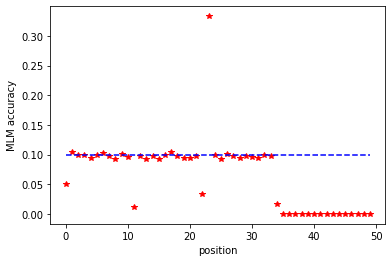

Epoch: 0 Pretraining Perplexity: 13.1896 Validation accuracy: 0.0419 Validation ppl: 25.8779 lr: 0.0005999404007685902


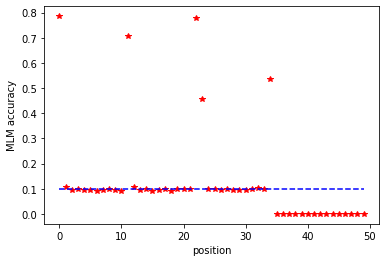

Epoch: 1 Pretraining Perplexity: 10.0259 Validation accuracy: 0.2268 Validation ppl: 7.6332 lr: 0.0005997609219172313


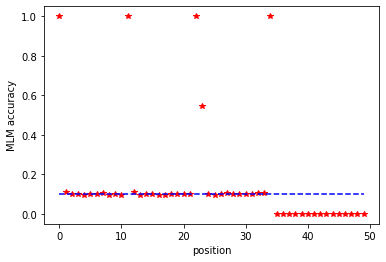

Epoch: 2 Pretraining Perplexity: 7.6857 Validation accuracy: 0.2050 Validation ppl: 7.5663 lr: 0.0005994616346595416


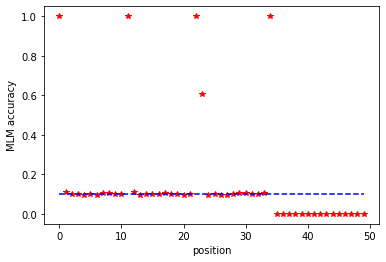

Epoch: 3 Pretraining Perplexity: 7.5580 Validation accuracy: 0.2406 Validation ppl: 7.3006 lr: 0.0005990426586146134


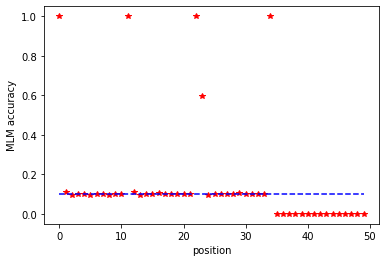

Epoch: 4 Pretraining Perplexity: 7.5100 Validation accuracy: 0.1964 Validation ppl: 7.7679 lr: 0.0005985041612387379


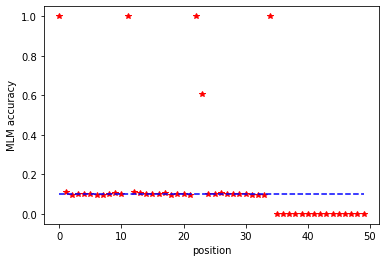

Epoch: 5 Pretraining Perplexity: 7.5118 Validation accuracy: 0.2201 Validation ppl: 7.5707 lr: 0.0005978463577584761


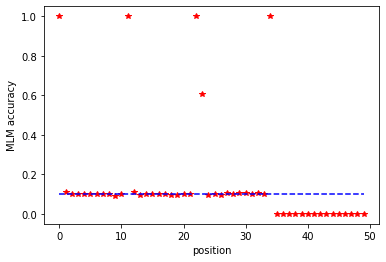

Epoch: 6 Pretraining Perplexity: 7.4864 Validation accuracy: 0.2255 Validation ppl: 7.2259 lr: 0.000597069511084638


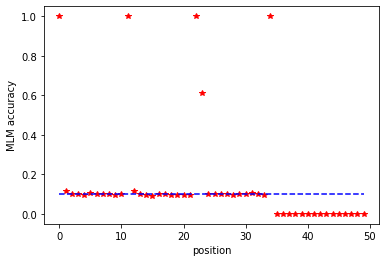

Epoch: 7 Pretraining Perplexity: 7.4637 Validation accuracy: 0.2206 Validation ppl: 7.3844 lr: 0.000596173931707201


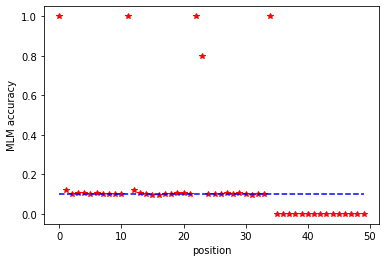

Epoch: 8 Pretraining Perplexity: 7.4102 Validation accuracy: 0.2229 Validation ppl: 7.3468 lr: 0.0005951599775712141


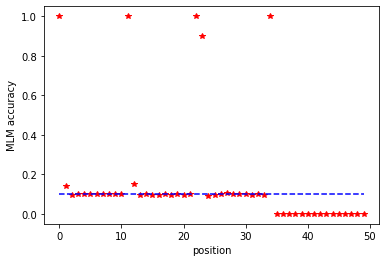

Epoch: 9 Pretraining Perplexity: 7.3614 Validation accuracy: 0.2379 Validation ppl: 7.0586 lr: 0.0005940280539337352


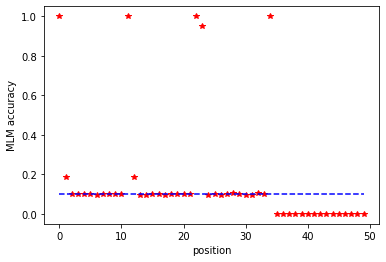

Epoch: 10 Pretraining Perplexity: 7.2735 Validation accuracy: 0.2172 Validation ppl: 7.4907 lr: 0.0005927786132018563


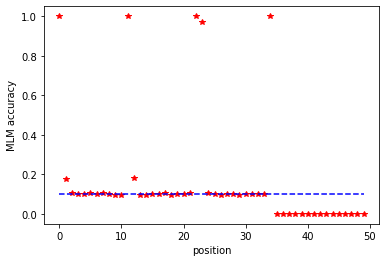

Epoch: 11 Pretraining Perplexity: 7.2446 Validation accuracy: 0.2303 Validation ppl: 7.2393 lr: 0.0005914121547518868


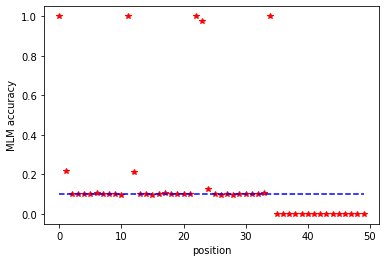

Epoch: 12 Pretraining Perplexity: 7.1963 Validation accuracy: 0.2332 Validation ppl: 7.2940 lr: 0.0005899292247297627


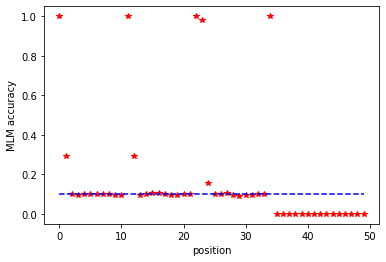

Epoch: 13 Pretraining Perplexity: 7.1426 Validation accuracy: 0.2488 Validation ppl: 6.9239 lr: 0.0005883304158327624


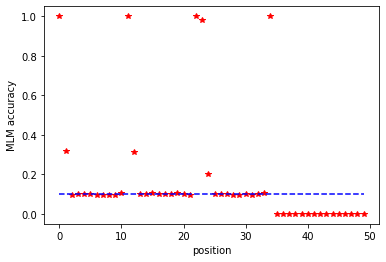

Epoch: 14 Pretraining Perplexity: 7.0561 Validation accuracy: 0.2634 Validation ppl: 6.7168 lr: 0.0005866163670726183


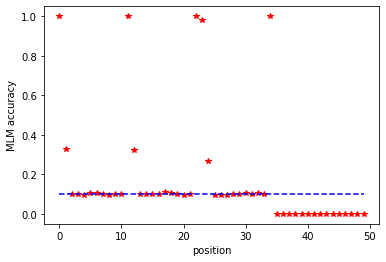

Epoch: 15 Pretraining Perplexity: 7.0022 Validation accuracy: 0.2607 Validation ppl: 6.7647 lr: 0.000584787763520116


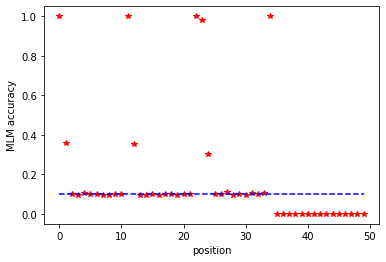

Epoch: 16 Pretraining Perplexity: 6.9556 Validation accuracy: 0.2642 Validation ppl: 7.0139 lr: 0.000582845336031286


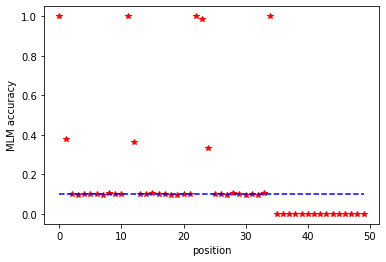

Epoch: 17 Pretraining Perplexity: 6.9339 Validation accuracy: 0.2698 Validation ppl: 6.6220 lr: 0.0005807898609552946


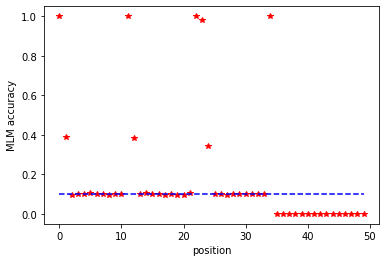

Epoch: 18 Pretraining Perplexity: 6.8915 Validation accuracy: 0.2641 Validation ppl: 6.6825 lr: 0.0005786221598241533


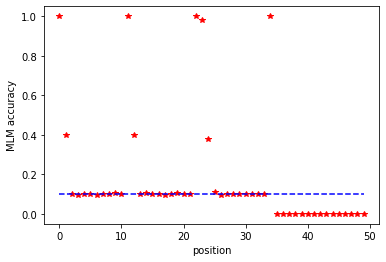

Epoch: 19 Pretraining Perplexity: 6.8575 Validation accuracy: 0.2675 Validation ppl: 6.6716 lr: 0.0005763430990243683


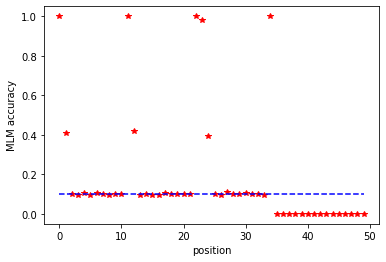

Epoch: 20 Pretraining Perplexity: 6.8272 Validation accuracy: 0.2508 Validation ppl: 7.0415 lr: 0.0005739535894506643


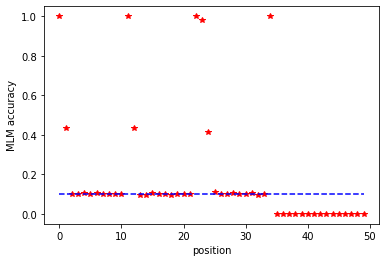

Epoch: 21 Pretraining Perplexity: 6.7980 Validation accuracy: 0.2710 Validation ppl: 6.5873 lr: 0.000571454586141917


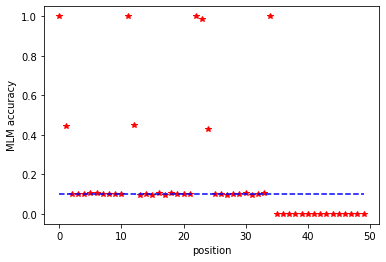

Epoch: 22 Pretraining Perplexity: 6.7778 Validation accuracy: 0.2736 Validation ppl: 6.5749 lr: 0.0005688470878994446


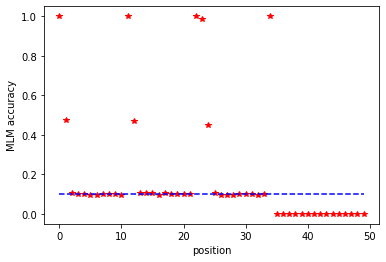

Epoch: 23 Pretraining Perplexity: 6.7303 Validation accuracy: 0.2879 Validation ppl: 6.3541 lr: 0.0005661321368878056


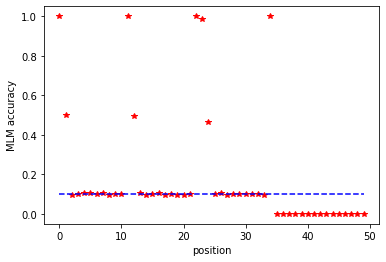

Epoch: 24 Pretraining Perplexity: 6.6939 Validation accuracy: 0.2590 Validation ppl: 6.7664 lr: 0.0005633108223531533


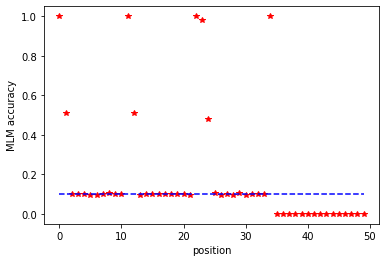

Epoch: 25 Pretraining Perplexity: 6.6892 Validation accuracy: 0.2936 Validation ppl: 6.3304 lr: 0.000560384268086027


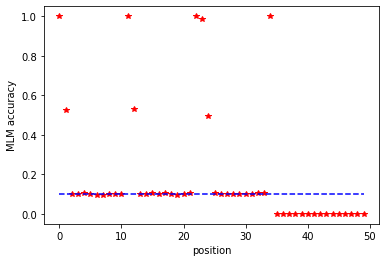

Epoch: 26 Pretraining Perplexity: 6.6383 Validation accuracy: 0.2770 Validation ppl: 6.4438 lr: 0.0005573536437678908


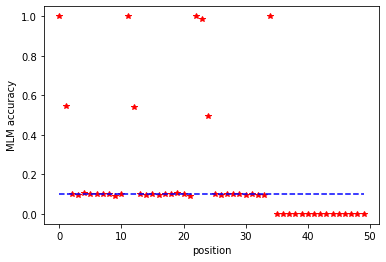

Epoch: 27 Pretraining Perplexity: 6.6293 Validation accuracy: 0.2826 Validation ppl: 6.3842 lr: 0.000554220160674793


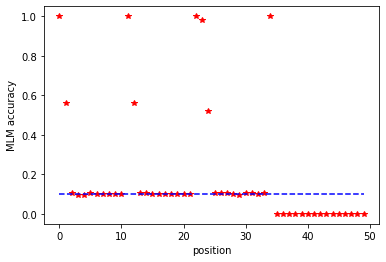

Epoch: 28 Pretraining Perplexity: 6.6025 Validation accuracy: 0.2900 Validation ppl: 6.2303 lr: 0.0005509850711932461


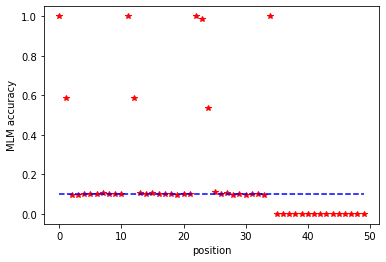

Epoch: 29 Pretraining Perplexity: 6.5682 Validation accuracy: 0.2651 Validation ppl: 6.4490 lr: 0.0005476496683196734


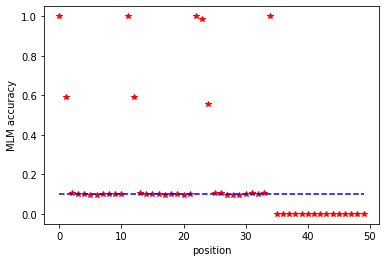

Epoch: 30 Pretraining Perplexity: 6.5520 Validation accuracy: 0.3027 Validation ppl: 6.1794 lr: 0.0005442152851436265


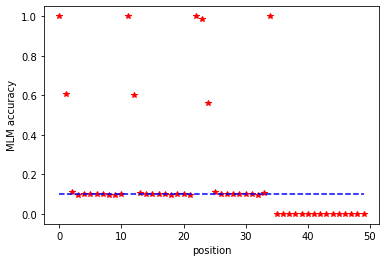

Epoch: 31 Pretraining Perplexity: 6.5259 Validation accuracy: 0.2697 Validation ppl: 6.3641 lr: 0.0005406832943149777


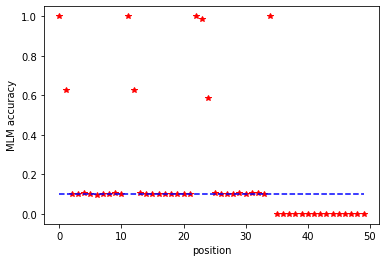

Epoch: 32 Pretraining Perplexity: 6.4995 Validation accuracy: 0.2884 Validation ppl: 6.2493 lr: 0.0005370551074953009


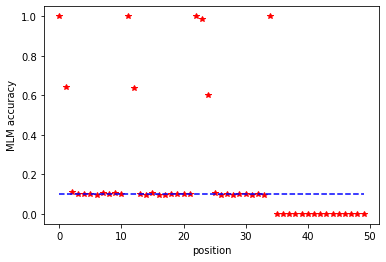

Epoch: 33 Pretraining Perplexity: 6.4683 Validation accuracy: 0.2698 Validation ppl: 6.4657 lr: 0.0005333321747936605


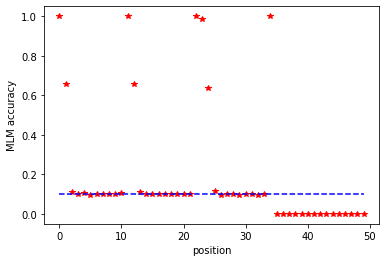

Epoch: 34 Pretraining Perplexity: 6.4542 Validation accuracy: 0.2691 Validation ppl: 6.4237 lr: 0.000529515984187034


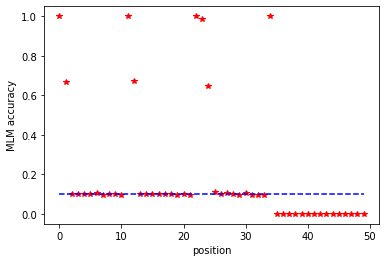

Epoch: 35 Pretraining Perplexity: 6.4356 Validation accuracy: 0.2764 Validation ppl: 6.4029 lr: 0.0005256080609255987


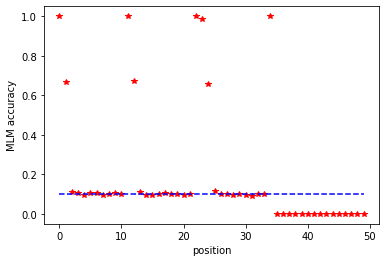

Epoch: 36 Pretraining Perplexity: 6.4232 Validation accuracy: 0.2566 Validation ppl: 6.5584 lr: 0.0005216099669231221


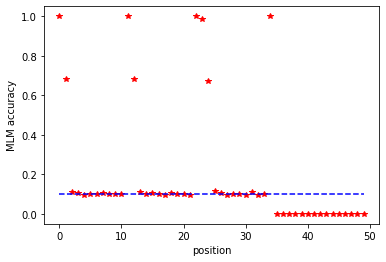

Epoch: 37 Pretraining Perplexity: 6.4176 Validation accuracy: 0.2982 Validation ppl: 6.1963 lr: 0.0005175233001326979


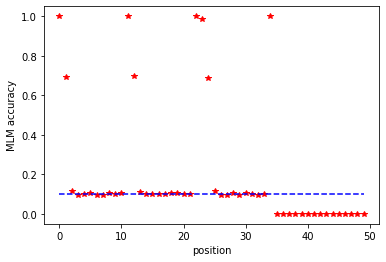

Epoch: 38 Pretraining Perplexity: 6.3890 Validation accuracy: 0.2890 Validation ppl: 6.3727 lr: 0.0005133496939080788


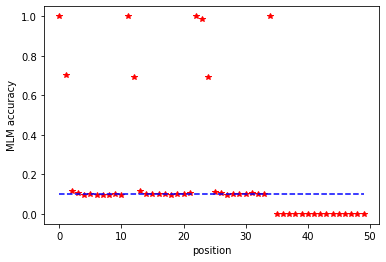

Epoch: 39 Pretraining Perplexity: 6.3937 Validation accuracy: 0.2777 Validation ppl: 6.2871 lr: 0.0005090908163508588


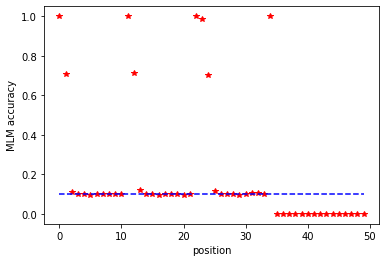

Epoch: 40 Pretraining Perplexity: 6.3603 Validation accuracy: 0.2729 Validation ppl: 6.2891 lr: 0.000504748369643769


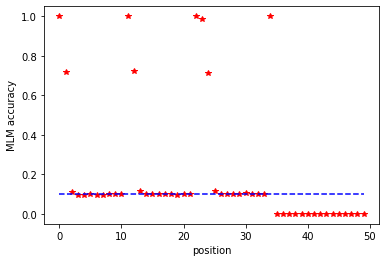

Epoch: 41 Pretraining Perplexity: 6.3710 Validation accuracy: 0.2751 Validation ppl: 6.3738 lr: 0.0005003240893703518


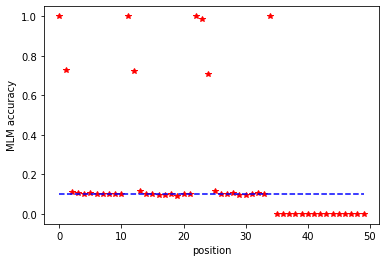

Epoch: 42 Pretraining Perplexity: 6.3599 Validation accuracy: 0.2839 Validation ppl: 6.4071 lr: 0.0004958197438212843


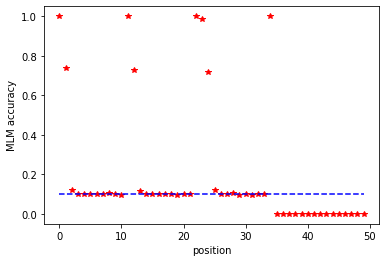

Epoch: 43 Pretraining Perplexity: 6.3358 Validation accuracy: 0.3071 Validation ppl: 6.0044 lr: 0.0004912371332876304


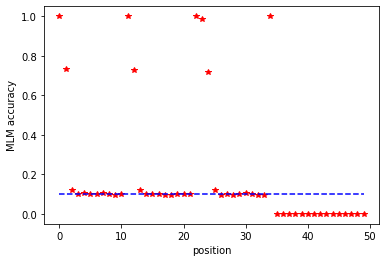

Epoch: 44 Pretraining Perplexity: 6.3260 Validation accuracy: 0.2861 Validation ppl: 6.4764 lr: 0.0004865780893413032


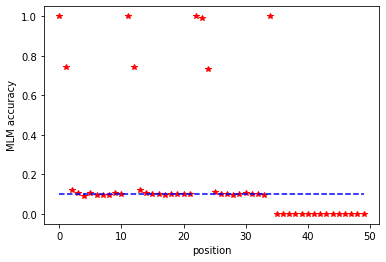

Epoch: 45 Pretraining Perplexity: 6.3040 Validation accuracy: 0.2848 Validation ppl: 6.3081 lr: 0.00048184447410302414


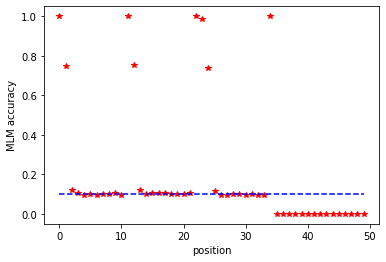

Epoch: 46 Pretraining Perplexity: 6.2860 Validation accuracy: 0.2881 Validation ppl: 6.3275 lr: 0.00047703817949807325


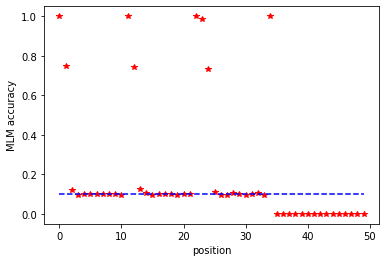

Epoch: 47 Pretraining Perplexity: 6.3056 Validation accuracy: 0.2937 Validation ppl: 6.3191 lr: 0.0004721611265001267


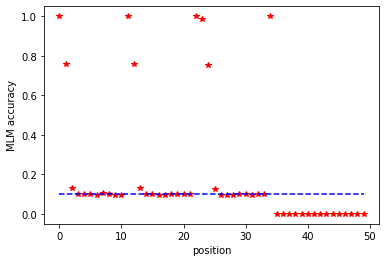

Epoch: 48 Pretraining Perplexity: 6.2878 Validation accuracy: 0.2800 Validation ppl: 6.3452 lr: 0.00046721526436348487


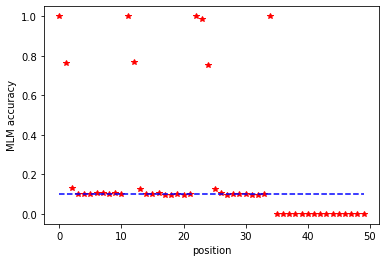

Epoch: 49 Pretraining Perplexity: 6.2791 Validation accuracy: 0.2972 Validation ppl: 6.1454 lr: 0.00046220256984399636


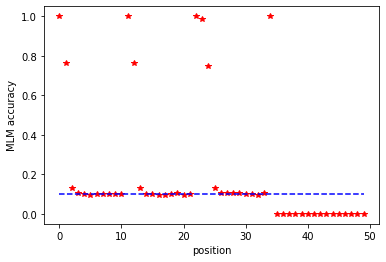

Epoch: 50 Pretraining Perplexity: 6.2644 Validation accuracy: 0.2909 Validation ppl: 6.0019 lr: 0.000457125046408991


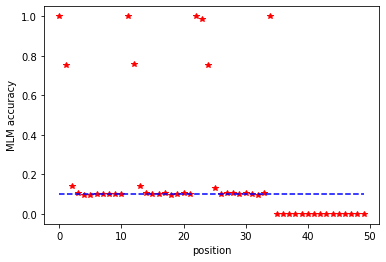

Epoch: 51 Pretraining Perplexity: 6.2518 Validation accuracy: 0.2945 Validation ppl: 6.1423 lr: 0.00045198472343653697


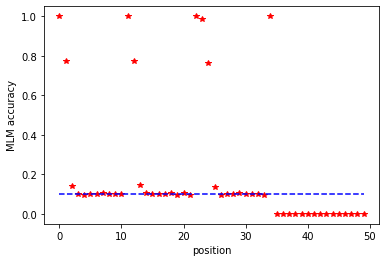

Epoch: 52 Pretraining Perplexity: 6.2396 Validation accuracy: 0.2919 Validation ppl: 6.0243 lr: 0.00044678365540434074


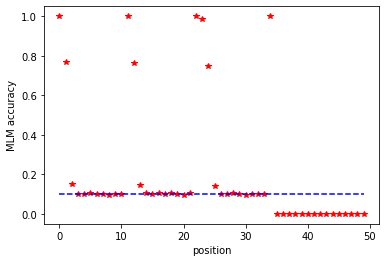

Epoch: 53 Pretraining Perplexity: 6.2320 Validation accuracy: 0.2708 Validation ppl: 6.3717 lr: 0.0004415239210686168


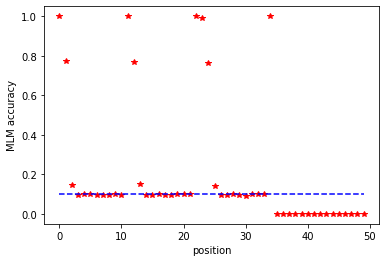

Epoch: 54 Pretraining Perplexity: 6.2225 Validation accuracy: 0.3008 Validation ppl: 6.1516 lr: 0.00043620762263325266


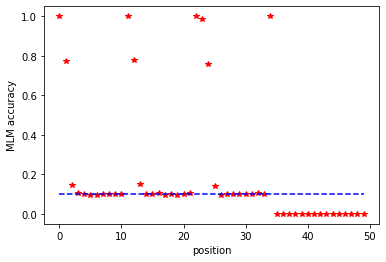

Epoch: 55 Pretraining Perplexity: 6.2069 Validation accuracy: 0.2829 Validation ppl: 6.2198 lr: 0.0004308368849096028


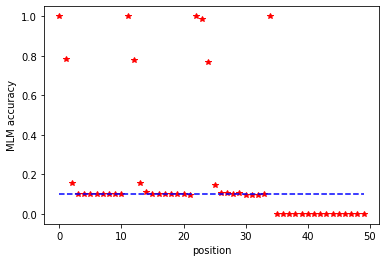

Epoch: 56 Pretraining Perplexity: 6.1995 Validation accuracy: 0.3021 Validation ppl: 6.1568 lr: 0.00042541385446724677


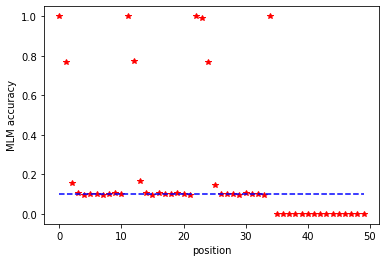

Epoch: 57 Pretraining Perplexity: 6.2006 Validation accuracy: 0.3132 Validation ppl: 5.8370 lr: 0.00041994069877605096


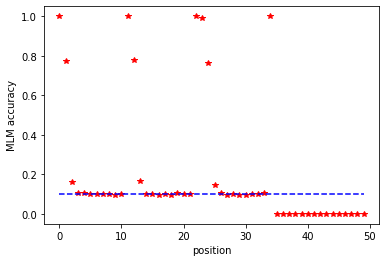

Epoch: 58 Pretraining Perplexity: 6.1995 Validation accuracy: 0.2911 Validation ppl: 6.2629 lr: 0.000414419605339877


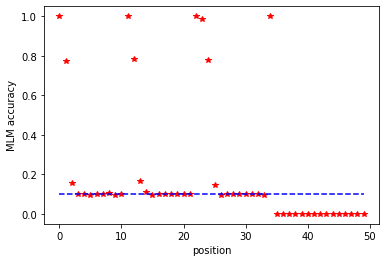

Epoch: 59 Pretraining Perplexity: 6.1776 Validation accuracy: 0.3047 Validation ppl: 6.1457 lr: 0.0004088527808222832


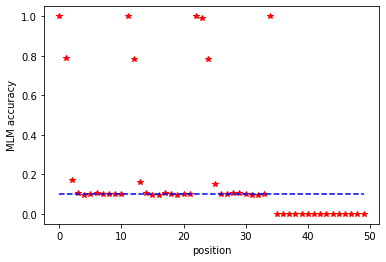

Epoch: 60 Pretraining Perplexity: 6.1749 Validation accuracy: 0.3054 Validation ppl: 6.0251 lr: 0.000403242450164568


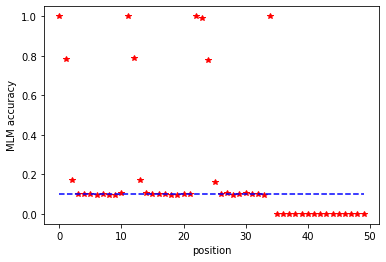

Epoch: 61 Pretraining Perplexity: 6.1681 Validation accuracy: 0.3144 Validation ppl: 5.8993 lr: 0.00039759085569650825


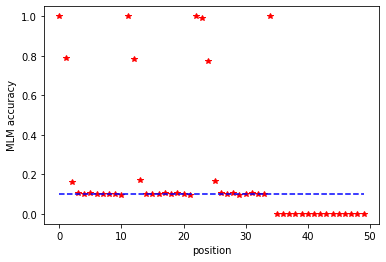

Epoch: 62 Pretraining Perplexity: 6.1524 Validation accuracy: 0.3132 Validation ppl: 5.9217 lr: 0.00039190025624014747


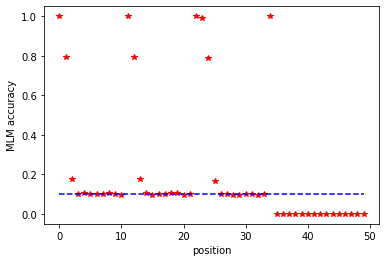

Epoch: 63 Pretraining Perplexity: 6.1439 Validation accuracy: 0.2864 Validation ppl: 5.9268 lr: 0.0003861729262069931


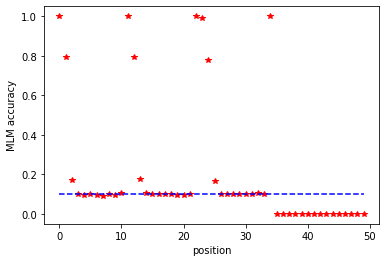

Epoch: 64 Pretraining Perplexity: 6.1471 Validation accuracy: 0.2698 Validation ppl: 6.3674 lr: 0.0003804111546889827


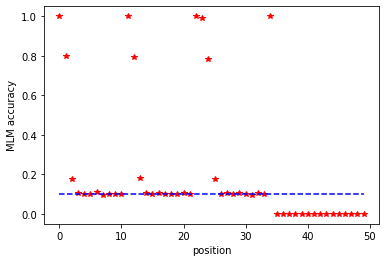

Epoch: 65 Pretraining Perplexity: 6.1270 Validation accuracy: 0.3043 Validation ppl: 5.9018 lr: 0.00037461724454358226


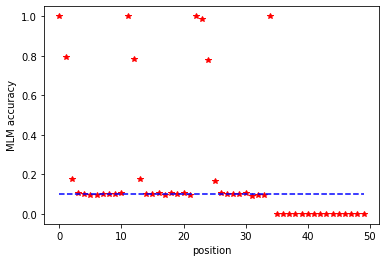

Epoch: 66 Pretraining Perplexity: 6.1250 Validation accuracy: 0.2990 Validation ppl: 6.1452 lr: 0.00036879351147338303


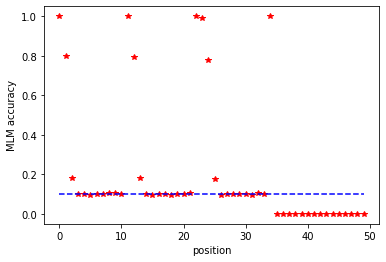

Epoch: 67 Pretraining Perplexity: 6.1213 Validation accuracy: 0.2875 Validation ppl: 6.0653 lr: 0.0003629422831005652


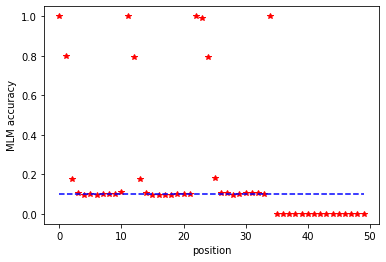

Epoch: 68 Pretraining Perplexity: 6.1132 Validation accuracy: 0.3194 Validation ppl: 5.7650 lr: 0.0003570658980365956


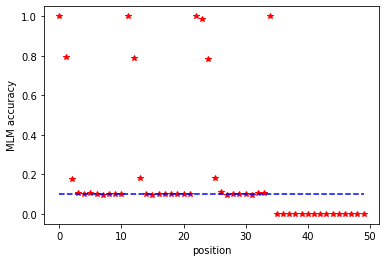

Epoch: 69 Pretraining Perplexity: 6.1109 Validation accuracy: 0.2883 Validation ppl: 6.0645 lr: 0.00035116670494753587


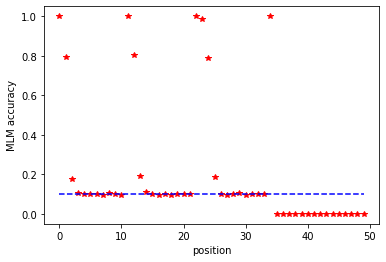

Epoch: 70 Pretraining Perplexity: 6.1119 Validation accuracy: 0.3128 Validation ppl: 6.0111 lr: 0.00034524706161532945


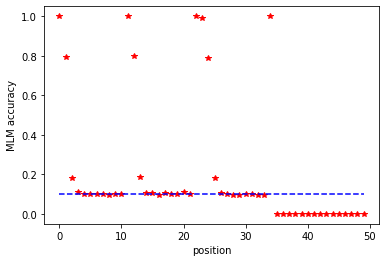

Epoch: 71 Pretraining Perplexity: 6.0934 Validation accuracy: 0.3222 Validation ppl: 5.7932 lr: 0.00033930933399544717


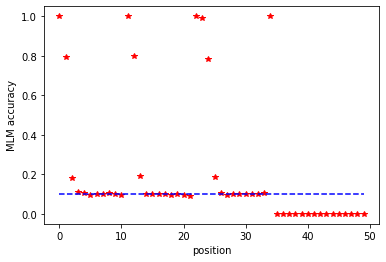

Epoch: 72 Pretraining Perplexity: 6.1090 Validation accuracy: 0.2802 Validation ppl: 6.0900 lr: 0.0003333558952712644


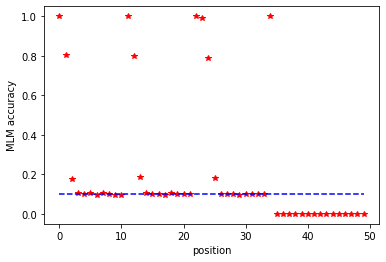

Epoch: 73 Pretraining Perplexity: 6.0976 Validation accuracy: 0.2859 Validation ppl: 6.0006 lr: 0.000327389124905551


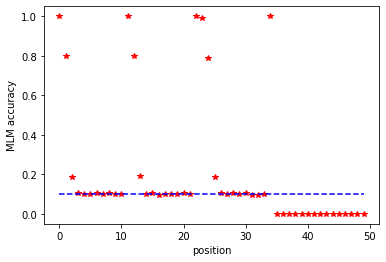

Epoch: 74 Pretraining Perplexity: 6.0927 Validation accuracy: 0.2790 Validation ppl: 6.1447 lr: 0.0003214114076894498


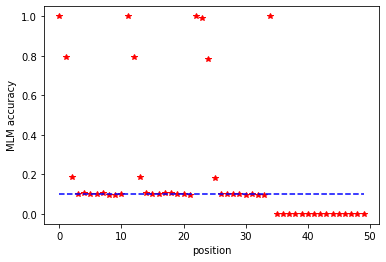

Epoch: 75 Pretraining Perplexity: 6.0897 Validation accuracy: 0.3078 Validation ppl: 5.8266 lr: 0.00031542513278932726


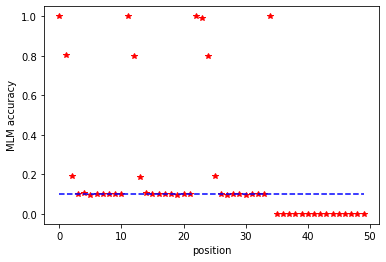

Epoch: 76 Pretraining Perplexity: 6.0622 Validation accuracy: 0.3065 Validation ppl: 5.9008 lr: 0.0003094326927918736


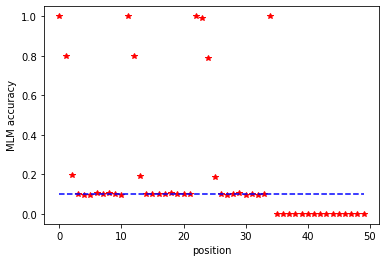

Epoch: 77 Pretraining Perplexity: 6.0692 Validation accuracy: 0.2909 Validation ppl: 6.0566 lr: 0.0003034364827478376


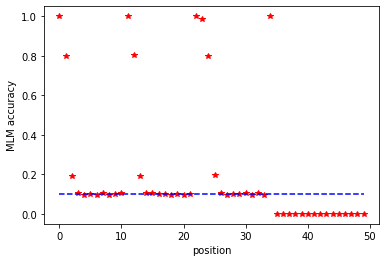

Epoch: 78 Pretraining Perplexity: 6.0632 Validation accuracy: 0.2884 Validation ppl: 5.9834 lr: 0.0002974388992147751


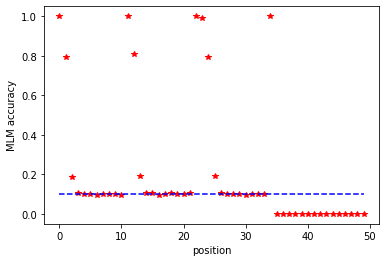

Epoch: 79 Pretraining Perplexity: 6.0758 Validation accuracy: 0.3032 Validation ppl: 5.9309 lr: 0.0002914423392991966


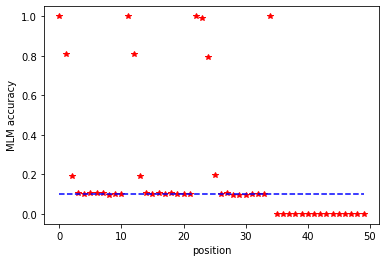

Epoch: 80 Pretraining Perplexity: 6.0682 Validation accuracy: 0.3055 Validation ppl: 5.8332 lr: 0.0002854491996984943


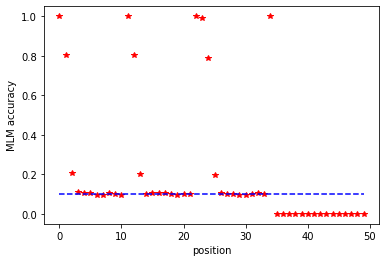

Epoch: 81 Pretraining Perplexity: 6.0639 Validation accuracy: 0.2905 Validation ppl: 6.0227 lr: 0.00027946187574303343


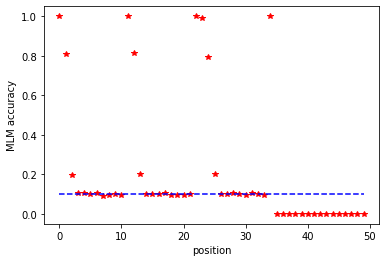

Epoch: 82 Pretraining Perplexity: 6.0535 Validation accuracy: 0.2919 Validation ppl: 5.9078 lr: 0.0002734827604387893


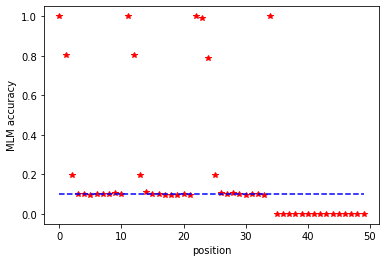

Epoch: 83 Pretraining Perplexity: 6.0579 Validation accuracy: 0.3027 Validation ppl: 6.0694 lr: 0.00026751424351091434


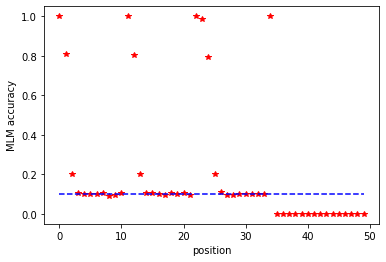

Epoch: 84 Pretraining Perplexity: 6.0612 Validation accuracy: 0.2752 Validation ppl: 6.3307 lr: 0.00026155871044861525


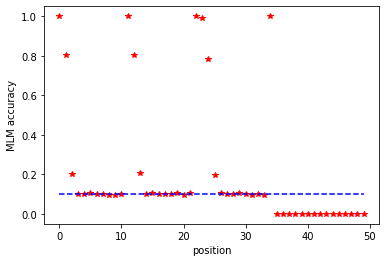

Epoch: 85 Pretraining Perplexity: 6.0379 Validation accuracy: 0.2871 Validation ppl: 5.9750 lr: 0.00025561854155172435


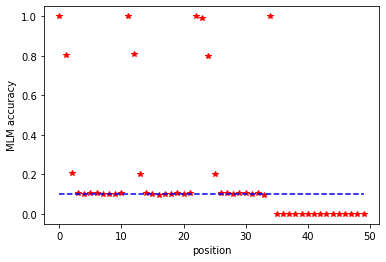

Epoch: 86 Pretraining Perplexity: 6.0243 Validation accuracy: 0.3248 Validation ppl: 5.8490 lr: 0.0002496961109793433


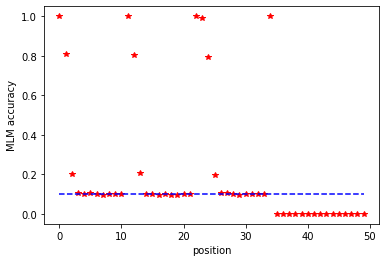

Epoch: 87 Pretraining Perplexity: 6.0500 Validation accuracy: 0.3178 Validation ppl: 5.9398 lr: 0.0002437937858009435


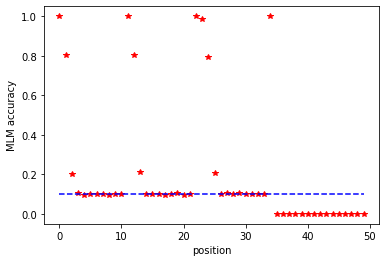

Epoch: 88 Pretraining Perplexity: 6.0418 Validation accuracy: 0.3034 Validation ppl: 6.0882 lr: 0.00023791392505029808


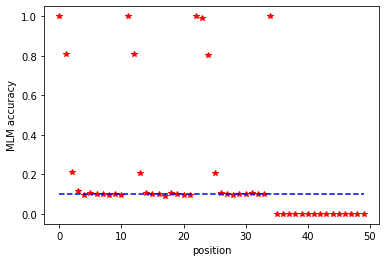

Epoch: 89 Pretraining Perplexity: 6.0406 Validation accuracy: 0.2817 Validation ppl: 6.1307 lr: 0.00023205887878262633


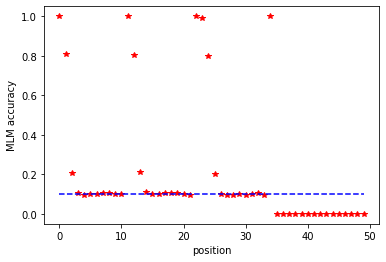

Epoch: 90 Pretraining Perplexity: 6.0387 Validation accuracy: 0.3030 Validation ppl: 5.9159 lr: 0.00022623098713532675


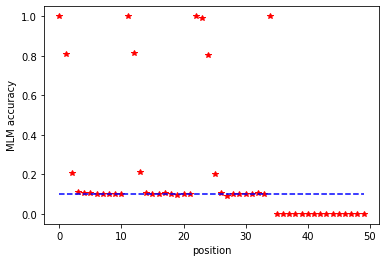

Epoch: 91 Pretraining Perplexity: 6.0434 Validation accuracy: 0.2884 Validation ppl: 5.9917 lr: 0.00022043257939267404


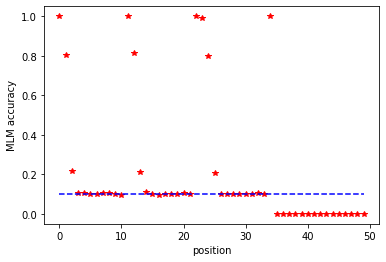

Epoch: 92 Pretraining Perplexity: 6.0188 Validation accuracy: 0.3017 Validation ppl: 6.1051 lr: 0.00021466597305485355


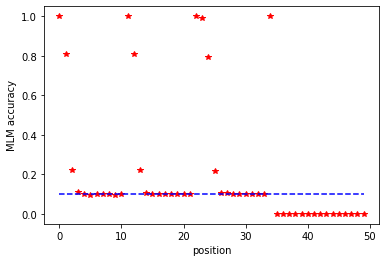

Epoch: 93 Pretraining Perplexity: 6.0214 Validation accuracy: 0.2867 Validation ppl: 5.9959 lr: 0.0002089334729117059


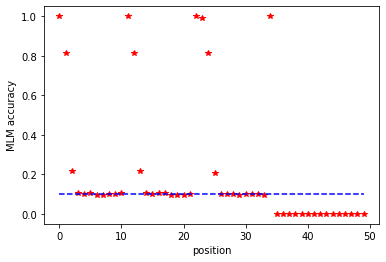

Epoch: 94 Pretraining Perplexity: 6.0009 Validation accuracy: 0.3189 Validation ppl: 5.7670 lr: 0.00020323737012155137


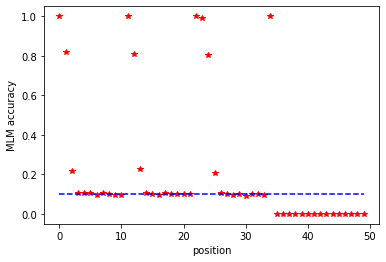

Epoch: 95 Pretraining Perplexity: 6.0264 Validation accuracy: 0.3072 Validation ppl: 5.9145 lr: 0.0001975799412954629


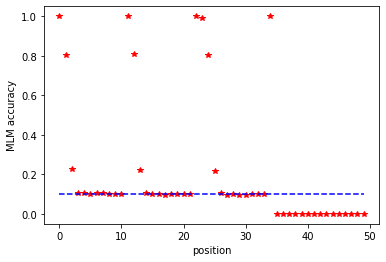

Epoch: 96 Pretraining Perplexity: 6.0049 Validation accuracy: 0.3064 Validation ppl: 5.8952 lr: 0.00019196341538858585


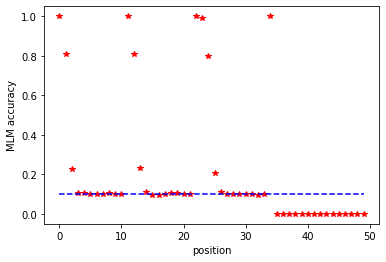

Epoch: 97 Pretraining Perplexity: 5.9990 Validation accuracy: 0.2916 Validation ppl: 6.0672 lr: 0.0001863900699025274


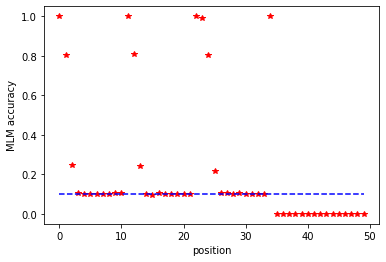

Epoch: 98 Pretraining Perplexity: 6.0052 Validation accuracy: 0.3006 Validation ppl: 5.9257 lr: 0.0001808621324105151


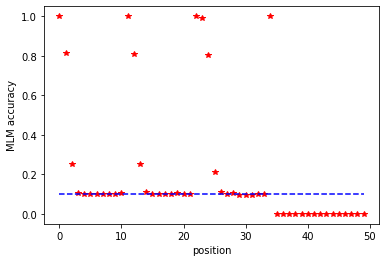

Epoch: 99 Pretraining Perplexity: 5.9944 Validation accuracy: 0.3022 Validation ppl: 5.9396 lr: 0.00017538181233695823


In [20]:
# OPTIONAL, you can skip this cell at the cost of performance
# This cell might take more than 10 minutes!
pretrained_path = 'discriminator_pretrained.pt'

# Instantiate a discriminator
discriminator_pretrain = Discriminator(
  text_field = TEXT, 
  hidden_size= 128, 
  layers     = 2, 
  heads      = 4
).to(device)

if not RETRAIN_PRETRAIN:
  if not os.path.exists(pretrained_path):
    print ('has to pretrain because checkpoint does not exist!')

if RETRAIN_PRETRAIN or (not os.path.exists(pretrained_path)):
  EPOCHS = 100
  LEARNING_RATE = 6e-4
  ACCUMULATE = 10

  discriminator_pretrain.pretrain_all(train_iter, val_iter, epochs=EPOCHS, 
                             learning_rate=LEARNING_RATE, accumulate=ACCUMULATE)
  torch.save(discriminator_pretrain.state_dict(), pretrained_path)
else:
  discriminator_pretrain.load_state_dict(torch.load(pretrained_path))

Now, we train our discriminator. Set `SKIP_PRETRAINING` to `True` or skip running the previous cell if you want to skip pretraining, which is unnecessary for this toy task.

In [21]:
EPOCHS = 50
LEARNING_RATE = 6e-4
SKIP_PRETRAINING = False # whether skip pretraining of discriminator or not

pretrained_path = 'discriminator_pretrained.pt'

discriminator = Discriminator(
    text_field = TEXT, 
    hidden_size= 128, 
    layers     = 2, 
    heads      = 4
  ).to(device)

if (not SKIP_PRETRAINING) and os.path.exists(pretrained_path):
  print ('Loading a pretrained model')
  discriminator.load_state_dict(discriminator_pretrain.state_dict())
  
discriminator.train_all(train_iter, lmgen_train_iter, val_iter, lmgen_val_iter, 
                        epochs=EPOCHS, learning_rate=LEARNING_RATE)
discriminator.load_state_dict(discriminator.best_model)

Loading a pretrained model
best model sofar
Epoch: 0 Training Perplexity: 2.0148 Validation accuracy: 0.5657 Validation ppl: 1.9770 lr: 0.0005940280539337352
best model sofar
Epoch: 1 Training Perplexity: 1.9886 Validation accuracy: 0.5900 Validation ppl: 1.9694 lr: 0.0005763430990243683
best model sofar
Epoch: 2 Training Perplexity: 1.9871 Validation accuracy: 0.5943 Validation ppl: 1.9665 lr: 0.0005476496390994928
best model sofar
Epoch: 3 Training Perplexity: 1.9810 Validation accuracy: 0.5829 Validation ppl: 1.9351 lr: 0.000509090717349297
best model sofar
Epoch: 4 Training Perplexity: 1.9402 Validation accuracy: 0.5686 Validation ppl: 1.9062 lr: 0.00046220238111847005
best model sofar
Epoch: 5 Training Perplexity: 1.8778 Validation accuracy: 0.6957 Validation ppl: 1.7779 lr: 0.00040885249136097943
best model sofar
Epoch: 6 Training Perplexity: 1.7600 Validation accuracy: 0.7314 Validation ppl: 1.6658 lr: 0.00035116631384624574
best model sofar
Epoch: 7 Training Perplexity: 1.6331 

<All keys matched successfully>

A trained discriminator should be able to assign higher scores (or lower energies) to real data, and lower scores (or higher energies) to LM generations. We can visualize the score distribution of real data versus LM generations to make sure that this is the case.

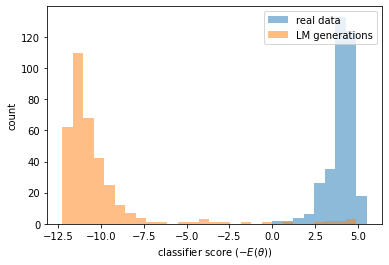

In [22]:
def get_scores(filename, max_size):
  scores = []
  with open(filename) as fin:
    i = 0
    for l in fin:
      i += 1
      if i > max_size:
        break
      sample = l.strip()
      text = TEXT.process([sample.split()])
      text = text.to(device)
      logits = discriminator.forward(text)
      l = logits[:, 0] - logits[:, 1]
      l = l.item()
      scores.append(l)
  return scores

scores_real = get_scores('data/val.txt', 1000)
scores_fake = get_scores('data/LM_generated/val.txt', 1000)

bins = np.linspace(min(scores_real+scores_fake), max(scores_real+scores_fake), 30)

plt.hist(scores_real, bins, alpha=0.5, label='real data')
plt.hist(scores_fake, bins, alpha=0.5, label='LM generations')
plt.legend(loc='upper right')
plt.xlabel(r'classifier score ($-E(\theta)$)')
plt.ylabel('count')
plt.show()

Now we can put everything together and run Algorithm 1 to generate from our joint model. In the below cell, we vary the number of samples (n in Algorithm 1) and evaluate the per-digit accuracy. We also plot an oracle curve which shows the best achievable accuracy (by selecting the best sample in the sample set) for comparison.

n: 1
n: 5
n: 10
n: 20
n: 40
n: 80


Text(0, 0.5, 'accuracy')

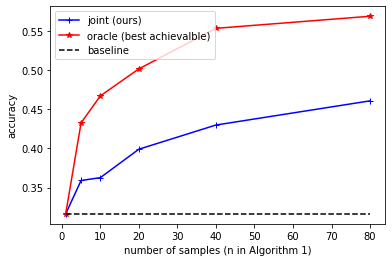

In [23]:
num_sentences = 100

ns = [1, 5, 10, 20, 40, 80]
oracle_accs = []
joint_accs = []
for n in ns:
  print (f'n: {n}')
  correct = 0
  total = 0
  num_correct_oracle = 0.
  num_correct_joint = 0.
  for i in range(num_sentences):
    sample_set = []
    scores = []
    best_acc = 0.
    for j in range(n):
      sample = generator.predict(1, None)[0]
      best_acc = max(best_acc, num_of_correct(sample)[0])
      sample_set.append(sample)

      text = TEXT.process([sample.split()])
      text = text.to(device)
      
      logits = discriminator.forward(text)
      score = logits[:, 0] - logits[:, 1]
      scores.append(score)
    scores = torch.Tensor(scores)
    scores[scores.ne(scores)] = 0
    probs = torch.softmax(scores, -1)
    probs = probs.numpy()
    probs = probs / probs.sum()
    sample = np.random.choice(sample_set, p=probs)
    num_correct_joint += num_of_correct(sample)[0]

    num_correct_oracle += best_acc
    total += 1
  joint_accs.append(num_correct_joint/total)
  oracle_accs.append(num_correct_oracle/total)

plt.plot(ns, joint_accs, 'b+-', label='joint (ours)')
plt.plot(ns, oracle_accs, 'r*-', label='oracle (best achievalble)')
plt.plot(ns, [joint_accs[0] for _ in ns], 'k--', label='baseline')
plt.legend()
plt.xlabel('number of samples (n in Algorithm 1)')
plt.ylabel('accuracy')

In the above curve, we can see that the accuracy increases as we sample more samples (increase n).